# NSGA-II baseline on ZDT1 (high dimensionality)

This notebook rebuilds the reference experiment from scratch to evaluate the computational
performance of our NSGA-II implementation across the ZDT problem family. The workflow covers
(1) the table with published results, (2) the full-budget baseline execution, and (3) the
analysis of the generated Pareto front so you can refresh the table with local runs.


## 1. Setup

This cell prepares the common dependencies for the rest of the notebook:
- Locates the VAMOS project root and adds `src/` to `PYTHONPATH` for code reuse.
- Applies Matplotlib/Pandas styles so the published table is easy to inspect.


In [11]:
from __future__ import annotations

import json
import os
import subprocess
import sys
import time
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

plt.style.use("seaborn-v0_8-whitegrid")
pd.set_option("display.max_rows", 30)
pd.set_option("display.max_columns", 10)
pd.set_option("display.width", 120)


def resolve_project_root(markers=("pyproject.toml", ".git")):
    current = Path.cwd().resolve()
    for candidate in (current, *current.parents):
        if any((candidate / marker).exists() for marker in markers):
            return candidate
    raise RuntimeError("Run this notebook inside the VAMOS repository tree.")


PROJECT_ROOT = resolve_project_root()
SRC_DIR = PROJECT_ROOT / "src"
RESULTS_DIR = PROJECT_ROOT / "results" / "ZDT1" / "nsgaii"

if SRC_DIR.exists() and str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

print("Project root:", PROJECT_ROOT)
print("Results dir:", RESULTS_DIR)


Project root: C:\Users\nicol\Desktop\VAMOS
Results dir: C:\Users\nicol\Desktop\VAMOS\results\ZDT1\nsgaii


## 2. Published baseline table

The following values come from the published results for both the manual NSGA-II
configuration and AutoNSGA-II at increasing dimensionality. The `NSGA-II-Nico` column is
reserved for logging the best measurement from your local runs.


In [12]:
def _record(problem, variables, time_nsga, time_auto, evals_nsga, evals_auto):
    return {
        "Problem": problem,
        "Variables": variables,
        "Time (h) NSGA-II": time_nsga,
        "Time (h) AutoNSGA-II": time_auto,
        "Evaluations NSGA-II": evals_nsga,
        "Evaluations AutoNSGA-II": evals_auto,
        "NSGA-II-Nico": "-",
    }

BASELINE_RECORDS = [
    _record("ZDT1", 2_048, 0.13, 0.02, 1_250_500, 182_356),
    _record("ZDT1", 4_096, 0.51, 0.12, 2_906_100, 484_356),
    _record("ZDT1", 8_192, 2.40, 0.50, 6_622_600, 1_039_156),
    _record("ZDT1", 16_384, 11.19, 2.15, 14_741_200, 2_180_656),
    _record("ZDT1", 32_768, None, 9.04, None, 4_605_556),
    _record("ZDT1", 65_356, None, 31.66, None, 9_494_556),
    _record("ZDT1", 131_072, None, 120.02, None, 19_359_356),
    _record("ZDT2", 2_048, 0.14, 0.02, 1_472_800, 164_756),
    _record("ZDT2", 4_096, 0.62, 0.10, 3_433_100, 429_156),
    _record("ZDT2", 8_192, 2.77, 0.49, 7_676_600, 986_556),
    _record("ZDT2", 16_384, 12.30, 2.28, 17_059_600, 2_358_056),
    _record("ZDT2", 32_768, None, 9.28, None, 4_736_056),
    _record("ZDT2", 65_356, None, 39.19, None, 10_081_856),
    _record("ZDT2", 131_072, None, 138.85, None, 21_703_556),
    _record("ZDT3", 2_048, 0.10, 0.03, 1_089_800, 253_356),
    _record("ZDT3", 4_096, 0.47, 0.16, 2_514_200, 610_956),
    _record("ZDT3", 8_192, 2.08, 0.62, 5_463_000, 1_267_656),
    _record("ZDT3", 16_384, 9.18, 2.68, 11_877_500, 2_820_556),
    _record("ZDT3", 32_768, None, 11.39, None, 6_158_256),
    _record("ZDT3", 65_356, None, 40.69, None, 11_912_856),
    _record("ZDT3", 131_072, None, None, None, None),
    _record("ZDT4*", 2_048, None, 2.62, None, 21_746_882),
    _record("ZDT6", 2_048, 0.45, 0.04, 5_401_100, 291_856),
    _record("ZDT6", 4_096, 1.82, 0.16, 11_482_400, 659_956),
    _record("ZDT6", 8_192, 7.16, 0.66, 24_897_300, 1_374_056),
    _record("ZDT6", 16_384, None, 3.08, None, 3_221_156),
    _record("ZDT6", 32_768, None, 15.51, None, 7_941_156),
    _record("ZDT6", 65_356, None, 63.79, None, 17_685_556),
    _record("ZDT6", 131_072, None, None, None, None),
]

baseline_df = pd.DataFrame(BASELINE_RECORDS)
display(baseline_df)


,Problem,Variables,Time (h) NSGA-II,Time (h) AutoNSGA-II,Evaluations NSGA-II,Evaluations AutoNSGA-II,NSGA-II-Nico
0,ZDT1,2048,0.13,0.02,1250500.0,182356.0,-
1,ZDT1,4096,0.51,0.12,2906100.0,484356.0,-
2,ZDT1,8192,2.40,0.50,6622600.0,1039156.0,-
3,ZDT1,16384,11.19,2.15,14741200.0,2180656.0,-
4,ZDT1,32768,NaN,9.04,NaN,4605556.0,-
5,ZDT1,65356,NaN,31.66,NaN,9494556.0,-
6,ZDT1,131072,NaN,120.02,NaN,19359356.0,-
7,ZDT2,2048,0.14,0.02,1472800.0,164756.0,-
8,ZDT2,4096,0.62,0.10,3433100.0,429156.0,-
9,ZDT2,8192,2.77,0.49,7676600.0,986556.0,-


## 3. Run the baseline (NSGA-II + moocore_v5)

The next cell launches the full-budget NSGA-II baseline. It runs `vamos.main` from the
project root so the artifacts land under `results/ZDT1/nsgaii/`. Adjust the arguments as
needed before uncommenting the function call.


In [13]:
def run_baseline(engine="moocore_v5", n_var=2_048, max_evaluations=12_500_500, hv_threshold=0.95):
    env = os.environ.copy()
    env.setdefault("PYTHONPATH", str(SRC_DIR))
    cmd = [
        sys.executable,
        "-m",
        "vamos.main",
        "--problem",
        "zdt1",
        "--engine",
        engine,
        "--n-var",
        str(n_var),
        "--max-evaluations",
        str(max_evaluations),
        "--hv-threshold",
        str(hv_threshold),
        "--population-size",
        "100",
        "--offspring-population-size",
        "100",
        "--nsgaii-crossover",
        "sbx",
        "--nsgaii-crossover-prob",
        "0.9",
        "--nsgaii-crossover-eta",
        "20",
        "--nsgaii-mutation",
        "pm",
        "--nsgaii-mutation-prob",
        "1/n",
        "--nsgaii-mutation-eta",
        "20",
        "--nsgaii-repair",
        "random",
        "--selection-pressure",
        "2",
    ]
    print("Running NSGA-II baseline with full evaluation budget...\n")
    print(" ".join(cmd))
    start = time.time()
    subprocess.run(cmd, env=env, cwd=str(PROJECT_ROOT), check=True)
    elapsed = time.time() - start
    hours = elapsed / 3600
    print(f"\nCompleted in {hours:.2f} hours (~{elapsed / 60:.1f} minutes).")
    return hours

# Descomenta la siguiente línea para ejecutar el baseline inmediatamente.
elapsed_hours = run_baseline()


Running NSGA-II baseline with full evaluation budget...

c:\Users\nicol\Desktop\VAMOS\.venv\Scripts\python.exe -m vamos.main --problem zdt1 --engine moocore_v5 --n-var 2048 --max-evaluations 12500500 --hv-threshold 0.95 --population-size 100 --offspring-population-size 100 --nsgaii-crossover sbx --nsgaii-crossover-prob 0.9 --nsgaii-crossover-eta 20 --nsgaii-mutation pm --nsgaii-mutation-prob 1/n --nsgaii-mutation-eta 20 --nsgaii-repair random --selection-pressure 2

Completed in 0.08 hours (~4.7 minutes).

Completed in 0.08 hours (~4.7 minutes).


## 4. Load the latest run and update the table

The `find_latest_run` helper scans `results/ZDT1/nsgaii/**/seed_*/metadata.json`, picks the
execution that matches `(problem = zdt1, n_var = 2048, max evaluations = 12,500,500)` and
updates `NSGA-II-Nico` with the measured wall-clock time.


In [14]:

if 'RESULTS_DIR' not in globals():
    if 'resolve_project_root' not in globals():
        raise RuntimeError('Run the setup cell first.')
    PROJECT_ROOT = resolve_project_root()
    SRC_DIR = PROJECT_ROOT / 'src'
    RESULTS_DIR = PROJECT_ROOT / 'results' / 'ZDT1' / 'nsgaii'
    if SRC_DIR.exists() and str(SRC_DIR) not in sys.path:
        sys.path.insert(0, str(SRC_DIR))


def find_latest_run(problem="zdt1", n_var=2_048, max_evaluations=12_500_500):
    if not RESULTS_DIR.exists():
        return None
    candidates = []
    for backend_dir in RESULTS_DIR.iterdir():
        if not backend_dir.is_dir():
            continue
        for meta_path in backend_dir.glob("seed_*/metadata.json"):
            with meta_path.open("r", encoding="utf-8") as fh:
                meta = json.load(fh)
            prob = meta.get("problem", {})
            if prob.get("key") != problem:
                continue
            if prob.get("n_var") != n_var:
                continue
            if meta.get("max_evaluations") != max_evaluations:
                continue
            candidates.append((meta_path.stat().st_mtime, meta_path, meta))
    if not candidates:
        return None
    return max(candidates, key=lambda item: item[0])

latest = find_latest_run()
if latest is None:
    print("No matching metadata found, ejecuta primero el baseline.")
    LATEST_RUN_PATH = None
    LATEST_FUN_PATH = None
else:
    _, meta_path, meta = latest
    hours = meta["metrics"]["time_ms"] / 1000 / 3600
    evals = meta["metrics"]["evaluations"]
    updated_df = baseline_df.copy()
    mask = (updated_df["Problem"] == "ZDT1") & (updated_df["Variables"] == 2_048)
    updated_df.loc[mask, "NSGA-II-Nico"] = f"{hours:.2f} h / {evals:,}"
    display(updated_df)
    LATEST_RUN_PATH = meta_path
    artifacts = meta.get("artifacts", {})
    fun_name = artifacts.get("fun", "FUN.csv")
    LATEST_FUN_PATH = meta_path.parent / fun_name
    print(f"Último metadata: {meta_path}")
    print(f"Frente Pareto (FUN): {LATEST_FUN_PATH}")


,Problem,Variables,Time (h) NSGA-II,Time (h) AutoNSGA-II,Evaluations NSGA-II,Evaluations AutoNSGA-II,NSGA-II-Nico
0,ZDT1,2048,0.13,0.02,1250500.0,182356.0,"0.08 h / 688,400"
1,ZDT1,4096,0.51,0.12,2906100.0,484356.0,-
2,ZDT1,8192,2.40,0.50,6622600.0,1039156.0,-
3,ZDT1,16384,11.19,2.15,14741200.0,2180656.0,-
4,ZDT1,32768,NaN,9.04,NaN,4605556.0,-
5,ZDT1,65356,NaN,31.66,NaN,9494556.0,-
6,ZDT1,131072,NaN,120.02,NaN,19359356.0,-
7,ZDT2,2048,0.14,0.02,1472800.0,164756.0,-
8,ZDT2,4096,0.62,0.10,3433100.0,429156.0,-
9,ZDT2,8192,2.77,0.49,7676600.0,986556.0,-


Último metadata: C:\Users\nicol\Desktop\VAMOS\results\ZDT1\nsgaii\moocore_v5\seed_42\metadata.json
Frente Pareto (FUN): C:\Users\nicol\Desktop\VAMOS\results\ZDT1\nsgaii\moocore_v5\seed_42\FUN.csv


## 5. Plot the most recent Pareto front

Once a matching `FUN.csv` exists for the run above, this cell loads the `(f1, f2)` pairs and
plots the approximate front.


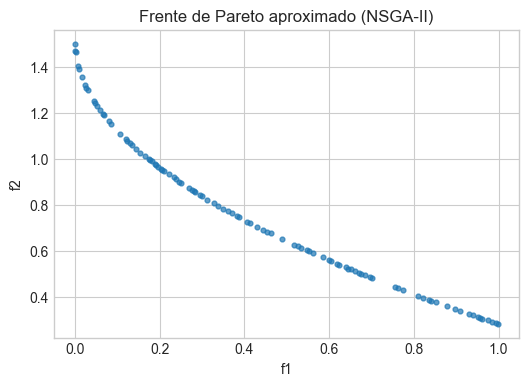

,f1,f2
count,100.0000,100.0000
mean,0.4239,0.7811
std,0.3074,0.3309
min,0.0001,0.2832
25%,0.1720,0.5103
50%,0.3665,0.7668
75%,0.6633,1.0012
max,0.9980,1.5002


In [15]:
fun_path = globals().get("LATEST_FUN_PATH")
if not fun_path or not Path(fun_path).exists():
    print("No Pareto front available. Run the metadata ingestion cell first.")
else:
    front = pd.read_csv(fun_path, header=None, names=["f1", "f2"])
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.scatter(front["f1"], front["f2"], s=12, alpha=0.7, color="#1f77b4")
    ax.set_xlabel("f1")
    ax.set_ylabel("f2")
    ax.set_title("Frente de Pareto aproximado (NSGA-II)")
    plt.show()
    display(front.describe().style.format(precision=4))
